Inspect connectivity from simulated networks.

In [1]:
using ProtoBuf
using neuralnets
using Gadfly

In [3]:
maxW = .5
EXC = 1
INH = 2

2

In [4]:
function weightMaps(netstate::NetworkState, chosen::Dict{ASCIIString,Int64},type_filter)

    # W = sum of pre and postsynaptic weights for chosen neurons across all layers
    W = [li=>zeros(layer.N) for (li,layer) in enumerate(netstate.layers)]
    # inverse mapping from names to layer index
    name2idx =[layer.name=>li for (li,layer) in enumerate(netstate.layers)]
    for (layer_name, neuron_idx) in chosen
        li = name2idx[layer_name]
        for spk_conn::SpikingConnection in netstate.connections
            # is a presynaptic layer, only viz recurr weights for post_conn
            source_idx = spk_conn.source + 1
            target_idx = spk_conn.target + 1

            if target_idx == li && source_idx != li 
            for syn::Synapse in spk_conn.synapses
                syn_t = syn.t+1
                syn_s = syn.s+1
                    if syn_t == neuron_idx && syn.stype == type_filter
                        W[source_idx][syn_s] += syn.w # TODO - fix indexing scheme
                    end
                end
            end

            # handle postsynaptic outgoing & recurrent synapses
            if source_idx == li
                for syn::Synapse in spk_conn.synapses
                    syn_t = syn.t+1
                    syn_s = syn.s+1
                    if syn_s == neuron_idx && syn.stype == type_filter
                        W[target_idx][syn_t] += syn.w
                    end
                end
            end
        end # end SpikingConnections

    # highlight the chosen neuron brightly
    W[li][neuron_idx]=maxW
    end # end chosen neurons
    W
end

weightMaps (generic function with 1 method)

In [5]:
function plotWeightMaps(W::Dict{Int64,Vector{Float64}}, layer_names)
    pp = Plot[]
    for li=1:length(W)
        width = int(sqrt(length(W[li])))
        data = reshape(W[li],width,width)
        data[data .== 0] = 1e-10
        p = spy(data,
        Scale.x_continuous(minvalue=0, maxvalue=width),
        Scale.y_continuous(minvalue=0, maxvalue=width),
        Scale.color_continuous(minvalue=0,maxvalue=maxW),
        Guide.title(layer_names[li]))
        push!(pp,p)
    end
    # this is the best guess I have at making subplots
    vstack(hstack(pp[1:3]),hstack(pp[4:6]),hstack(pp[7:9]))
end

plotWeightMaps (generic function with 1 method)

In [15]:
fname = "../../data/tests/test_1.protodat"
stream = open(fname,"r")
sim_results = readproto(stream,SimulationResults())
close(stream)

In [16]:
center10 = sub2ind([10,10],[5,5])
center30 = sub2ind([30,30],[15,15])
br30 = sub2ind([30,30],[23,23])
ul30 = sub2ind([30,30],[1,1])
ul10 = sub2ind([10,10],[1,1])
#chosen = ["P_L"=>center10,"LGN_C2"=>br30];
chosen = ["P_L"=> sub2ind([10,10],[1,2])];

W = weightMaps(sim_results.nstate, chosen, EXC);

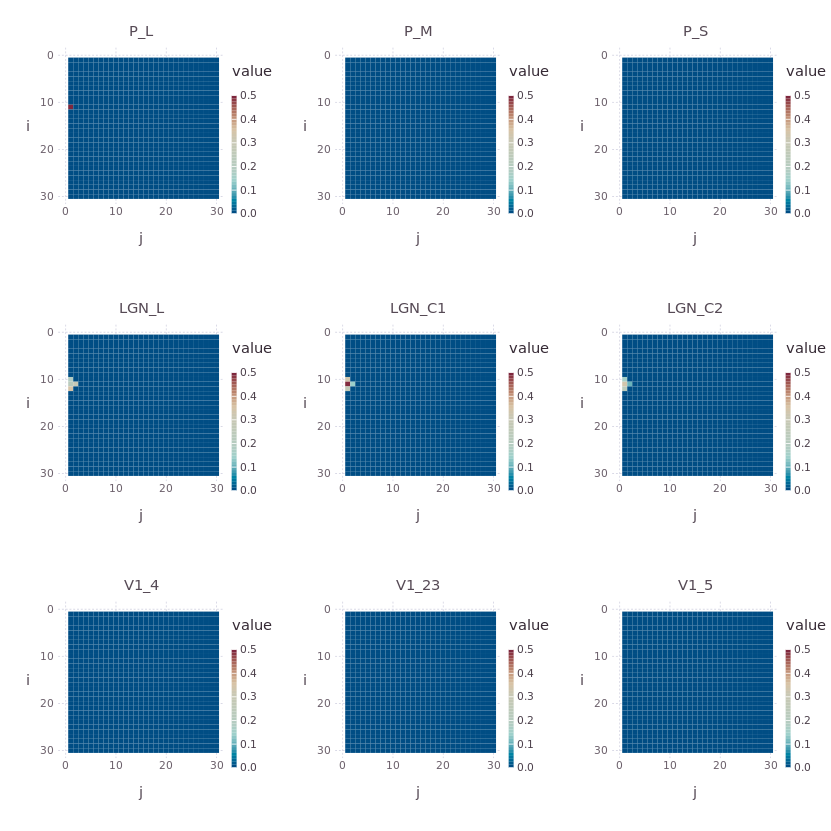

In [17]:
set_default_plot_size(22cm, 22cm)
plotWeightMaps(W, [layer.name for layer in sim_results.nstate.layers])


In [8]:
maximum(W[1])

0.5